<a href="https://colab.research.google.com/github/The20thDuck/MNIST_GAN/blob/main/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch as t
import torchvision
from tqdm import tqdm

In [ ]:
batch_size = 100
mnist_data = torchvision.datasets.MNIST('mnist', download=True, transform=torchvision.transforms.ToTensor())
data_loader = t.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True)

In [ ]:
mnist_data[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [ ]:
hidden_size = 256
latent_size = 64
class Discriminator(t.nn.Module):
  def __init__(self, hidden_size = hidden_size):
    super().__init__()
    self.layers = t.nn.Sequential(
        t.nn.Linear(28*28, hidden_size),
        t.nn.LeakyReLU(0.2),
        t.nn.Linear(hidden_size, hidden_size),
        t.nn.LeakyReLU(0.2),
        t.nn.Linear(hidden_size, 1),
        t.nn.Sigmoid()
    )
  def forward(self, x):
    return self.layers(x)

class Generator(t.nn.Module):
  def __init__(self, hidden_size = 256, latent_size = latent_size):
    super().__init__()
    self.layers = t.nn.Sequential(
        t.nn.Linear(latent_size, hidden_size),
        t.nn.ReLU(),
        t.nn.Linear(hidden_size, hidden_size),
        t.nn.ReLU(),
        t.nn.Linear(hidden_size, 28*28),
        t.nn.Sigmoid()
    )
  
  def forward(self, x):
    return self.layers(x)

In [ ]:
## Training
generator = Generator().cuda()
discriminator = Discriminator().cuda()

g_optimizer = t.optim.Adam(generator.parameters(), lr = 0.0002)
d_optimizer = t.optim.Adam(discriminator.parameters(), lr = 0.0002)



In [38]:
num_epochs = 5

for epoch in range(num_epochs):
  d_losses, g_losses = [], []
  for x, y in tqdm(data_loader):
    # zero grad
    generator.zero_grad()
    discriminator.zero_grad()
    # generate fake images
    with t.no_grad():
      z = t.randn((batch_size, latent_size))
      z = z.cuda()
    samples = generator(z)

    # get predictions
    x = x.cuda()
    x = t.reshape(x, (batch_size, 28*28))
    preds_real = discriminator(x)
    preds_samples = discriminator(samples)

    # update generator
    samples = generator(z)
    preds_samples = discriminator(samples)
    loss_g = t.nn.BCELoss()(preds_samples, t.ones(preds_real.shape).cuda()) # non-saturating heuristic
    g_losses.append(loss_g.item())

    loss_g.backward()
    g_optimizer.step()

    # update discriminator
    discriminator.zero_grad()
    loss_real = t.nn.BCELoss()(preds_real, t.ones(preds_real.shape).cuda())
    loss_samples = t.nn.BCELoss()(discriminator(samples.detach()), t.zeros(preds_samples.shape).cuda())
    loss_d = loss_real + loss_samples # no one-sided smoothing
    d_losses.append(loss_d.item())

    # calc gradients and step optimizers
    loss_d.backward()
    d_optimizer.step()

 
  print(f'd loss:{t.tensor(d_losses).mean()}, g loss: {t.tensor(g_losses).mean()}')

100%|██████████| 600/600 [00:13<00:00, 43.63it/s]


d loss:0.6011066436767578, g loss: 2.2037253379821777


100%|██████████| 600/600 [00:11<00:00, 50.37it/s]


d loss:0.6130397319793701, g loss: 2.1826934814453125


100%|██████████| 600/600 [00:13<00:00, 45.98it/s]


d loss:0.6166704297065735, g loss: 2.143484354019165


100%|██████████| 600/600 [00:12<00:00, 49.05it/s]


d loss:0.6218780875205994, g loss: 2.121554374694824


100%|██████████| 600/600 [00:11<00:00, 50.60it/s]

d loss:0.6258121132850647, g loss: 2.114786386489868


In [ ]:
import matplotlib.pyplot as plt


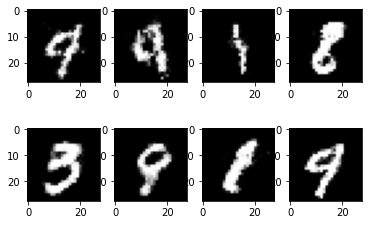

In [37]:
with t.no_grad():
  z = t.randn((batch_size, latent_size))
  z = z.cuda()
  samples = generator(z)
for i in range(8):
  plt.subplot(2, 4, i+1)
  plt.imshow(t.reshape(samples[i].cpu(), (28, 28)), cmap="gray")